In [1]:
import numpy as np
import matplotlib.pyplot as plt


def preprocess(text: str):
    text = text.lower()
    text = text.replace(".", " .")
    words = text.split(" ")
    word2id: dict[str, int] = {}
    id2word: dict[int, str] = {}
    for word in words:
        if word not in word2id:
            new_id = len(word2id)
            word2id[word] = new_id
            id2word[new_id] = word

    corpus = np.array([word2id[w] for w in words])
    return corpus, word2id, id2word


def create_co_matrix(corpus: np.ndarray, vocab_size: int, window_size: int = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx-i
            right_idx = idx+i

            if (left_idx >= 0):
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def cos_similarity(x: np.ndarray, y: np.ndarray, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2)+eps)
    ny = y / np.sqrt(np.sum(y**2)+eps)
    return nx @ ny


def most_similar(query: str, word2id: dict[str, int], id2word: dict[int, str], word_matrix: np.ndarray, top: int = 5):
    if query not in word2id:
        raise KeyError(f"{query} is not found")

    print(f"[query] {query}")
    query_id = word2id[query]
    query_vec = word_matrix[query_id]

    similarity = np.array([cos_similarity(x, query_vec) for x in word_matrix])
    similarity[query_id] = -1

    for i in (-similarity).argsort()[:top]:
        print(f" {id2word[i]}: {similarity[i]}")


In [30]:
def ppmi(C: np.ndarray, verbose=False, eps=1e-8):
    S = np.sum(C, axis=1)
    N = np.sum(S)
    CxCy = np.outer(S, S)

    pmi = np.log2((C/CxCy)*N+eps)

    return np.maximum(0, pmi)


def ppmi_slow(C, verbose=False, eps=1e-8):
    '''PPMI（正の相互情報量）の作成
    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M


C = np.array([[0, 2, 0], [2, 0, 1], [0, 1, 0]])
np.testing.assert_almost_equal(ppmi(C), ppmi_slow(C))

C = np.array([[0, 1, 2, 3], [1, 0, 2, 1], [2, 2, 0, 0], [3, 1, 0, 0]])
np.testing.assert_almost_equal(ppmi(C), ppmi_slow(C))


len(CxCy<0) == 0
len(C*N<0) == 0
len(x<0) == 0
len(CxCy<0) == 0
len(C*N<0) == 0
len(x<0) == 0


In [4]:
text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)


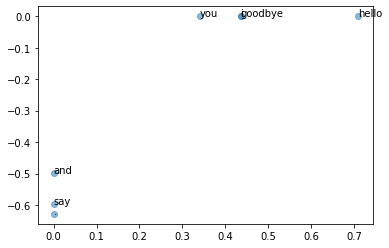

In [5]:

C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
U, S, V = np.linalg.svd(W)

for word, word_id in word2id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()


In [6]:
from dataset import ptb

corpus, word2id, id2word = ptb.load_data('train')

print(f"corpus size: {len(corpus)}")
print(f"corpus[:30]: {corpus[:30]}")
print()
print(f"id2word[0]", id2word[0])
print(f"id2word[1]", id2word[1])
print(f"id2word[2]", id2word[2])
print()
print("word2id['car']", word2id['car'])
print("word2id['happy']", word2id['happy'])
print("word2id['lexus']", word2id['lexus'])


corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id2word[0] aer
id2word[1] banknote
id2word[2] berlitz

word2id['car'] 3856
word2id['happy'] 4428
word2id['lexus'] 7426


In [33]:
window_size = 2
wordvec_size = 100
corpus, word2id, id2word = ptb.load_data("train")
vocab_size = len(word2id)
print("counting co-occurance ...")
C = create_co_matrix(corpus, vocab_size, window_size)

print("calculating PPMI ...")
W = ppmi(C, verbose=True)


counting co-occurance ...
calculating PPMI ...
len(CxCy<0) == 0
len(C*N<0) == 231
len(x<0) == 231


In [ ]:
print("calculating SVD ...")
U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

queries = ["you", "year", "car", "toyota"]
for q in queries:
    most_similar(q, word2id, id2word, word_vecs, top=5)